In [1]:
%load_ext tikzmagic
%matplotlib inline

# 가중치 검정

앞 절에서 선형회귀분석을 사용하여 계산한 가중치의 추정값 $\hat{w}$은 자연법칙에서 정해진 정확한 가중치 $w$와 다를 수 있다고 하였다. 팁 데이터를 사용하여 이 사실을 좀 더 자세히 설명한다.

우리는 현재 다음과 같은 244개 레코드의 팁 데이터를 가지고 있다.

In [3]:
import seaborn as sns

tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


하지만 이 팁 데이터는 특정한 기간동안 식당에서 수집한 데이터일 것이다. 이 데이터를 수집하기 전에도 데이터는 계속 나오고 있었고 수집과정이 끝난 이후에도 데이터는 계속 생성되어 나올 것이다.
만약 우리가 선형회귀분석으로 구한 가중치가 자연법칙에 의해 정해진 정확한 값이라면 이 데이터 뿐 아니라 다른 시점에 나온 데이터를 쓴다고 하더라고 같은 가중치가 나와야 할 것이다. 
같은 논리로 우리가 가진 244개의 데이터 중 일부만 사용하여 가중치를 계산한다고 하더라고 항상 같은 값이 나와야 한다. 이 사실을 검증하기 위해 244개의 데이터를 122개씩 2개의 데이터셋으로 나누어 각각 가중치를 구해보자

In [4]:
tips1 = tips.iloc[:122]
tips2 = tips.iloc[122:]

앞부분 절반의 데이터만 사용하여 가중치를 구해보자. 일단 모형 문자열은 앞에서 사용한 것과 같다.

In [13]:
import statsmodels.api as sm

formula = "tip ~ scale(total_bill) + scale(size) + C(sex)"

In [14]:
result1 = sm.OLS.from_formula(formula, tips1).fit()
result1.params

Intercept            3.090691
C(sex)[T.Female]    -0.116007
scale(total_bill)    0.877198
scale(size)          0.061576
dtype: float64

이번에는 뒷부분 절반의 데이터만 사용하여 가중치를 구한 결과이다.

In [15]:
result2 = sm.OLS.from_formula(formula, tips2).fit()
result2.params

Intercept            2.878103
C(sex)[T.Female]     0.164822
scale(total_bill)    0.788890
scale(size)          0.300813
dtype: float64

두 선형회귀분석 결과가 서로 다르다는 것을 알 수 있다. 심지어 sex 데이터의 가중치는 부호조차 서로 다르다. 이 결과를 따르자면 만약 데이터 수집을 더 진행하여 추가적인 데이터를 얻으면 선형회귀분석의 결과가 달라질 수도 있다는 뜻이다. 

두 데이터셋이 수집되는 동안 자연법칙이 변하지 않았다면 결론은 우리가 구한 가중치의 추정값 $\hat{w}$이 자연법칙이 내장하고 있는 정확한 가중치 $w$가 아니라는 뜻이다. 즉 가중치의 추정값은 오차를 가지고 있다. 이러한 오차가 발생하는 근본적인 원인은 우리가 가진 데이터가 제한적이기 때문이다. 

## 부트스트래핑을 사용한 가중치 추정값의 오차범위 계산

그러면 가중치 추정값이 가지는 오차의 크기가 어느 정도인지 알 수 있는 방법은 없을까? 정확한 오차를 계산하기 위해서는 뒤에서 설명할 몇가지 가정이 필요하지만 일단 부트스프래핑(boot-straping)이라는 간단한 방법으로 오차의 크기를 짐작해 볼 수 있다.  

<b>부트스프래핑(boot-straping)</b>은 전체 데이터에서 일부 데이터만 무작위로 골라서 선형회귀분석을 하는 것을 반복하는 것이다. 한번 무작위 선택 후 선형회귀분석을 실시하면 하나의 가중치 추정값 세트가 나온다. 또 한번 다시 데이터를 무작위 선택하여 선형회귀분석을 실시하면 또다른 가중치 추정값 세트가 나온다. 이 과정을 1000번 반복하면 1000개의 가중치 추정값 세트가 나오게 된다. 이렇게 나온 1000개의 가중치 추정값의 분포를 살펴보면 대략적으로 가중치 추정값이 어떤 범위에 있는지 살펴볼 수 있다.

다음 코드는 1000번의 반복 부트스트래핑을 통해 1000개의 가중치 추정값 세트를 구하는 코드다. 1000번의 선형회귀분석을 반복해야해서 실행시간이 길다. 코드 앞부분의 `%%time`은 코드의 실행시간을 출력하는 주피터 노트북 매직명령이다. 저자의 컴퓨터에서는 10초 이상의 시간이 걸렸다.

In [64]:
%%time

import numpy as np
import pandas as pd

np.random.seed(0)
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
params_w2 = np.zeros(N)
params_w3 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(tips), len(tips), replace=True)
    tips_i = tips.iloc[idx]
    result = sm.OLS.from_formula(formula, tips_i).fit()
    params_w0[i] = result.params.iloc[0]
    params_w1[i] = result.params.iloc[1]
    params_w2[i] = result.params.iloc[2]
    params_w3[i] = result.params.iloc[3]

weights = pd.DataFrame({
    "w_0": params_w0,
    "w_sex": params_w1,
    "w_total_bill": params_w2,
    "w_size": params_w3,
})
weights

CPU times: total: 15.8 s
Wall time: 15.9 s


,w_0,w_sex,w_total_bill,w_size
0,2.932750,0.005990,0.718988,0.227791
1,3.084244,0.087494,0.995008,0.049014
2,2.839063,0.034984,0.634239,0.285801
3,2.978962,0.032246,0.655065,0.034758
4,2.888683,0.075727,0.799001,0.162599
...,...,...,...,...
995,2.863593,0.023681,0.767523,0.253856
996,2.826096,0.268302,0.683563,0.227148
997,2.945665,0.049849,1.045534,0.047011
998,2.992950,0.013680,0.751426,0.206695


이 결과를 히스토그램으로 나타내면 다음과 같다.

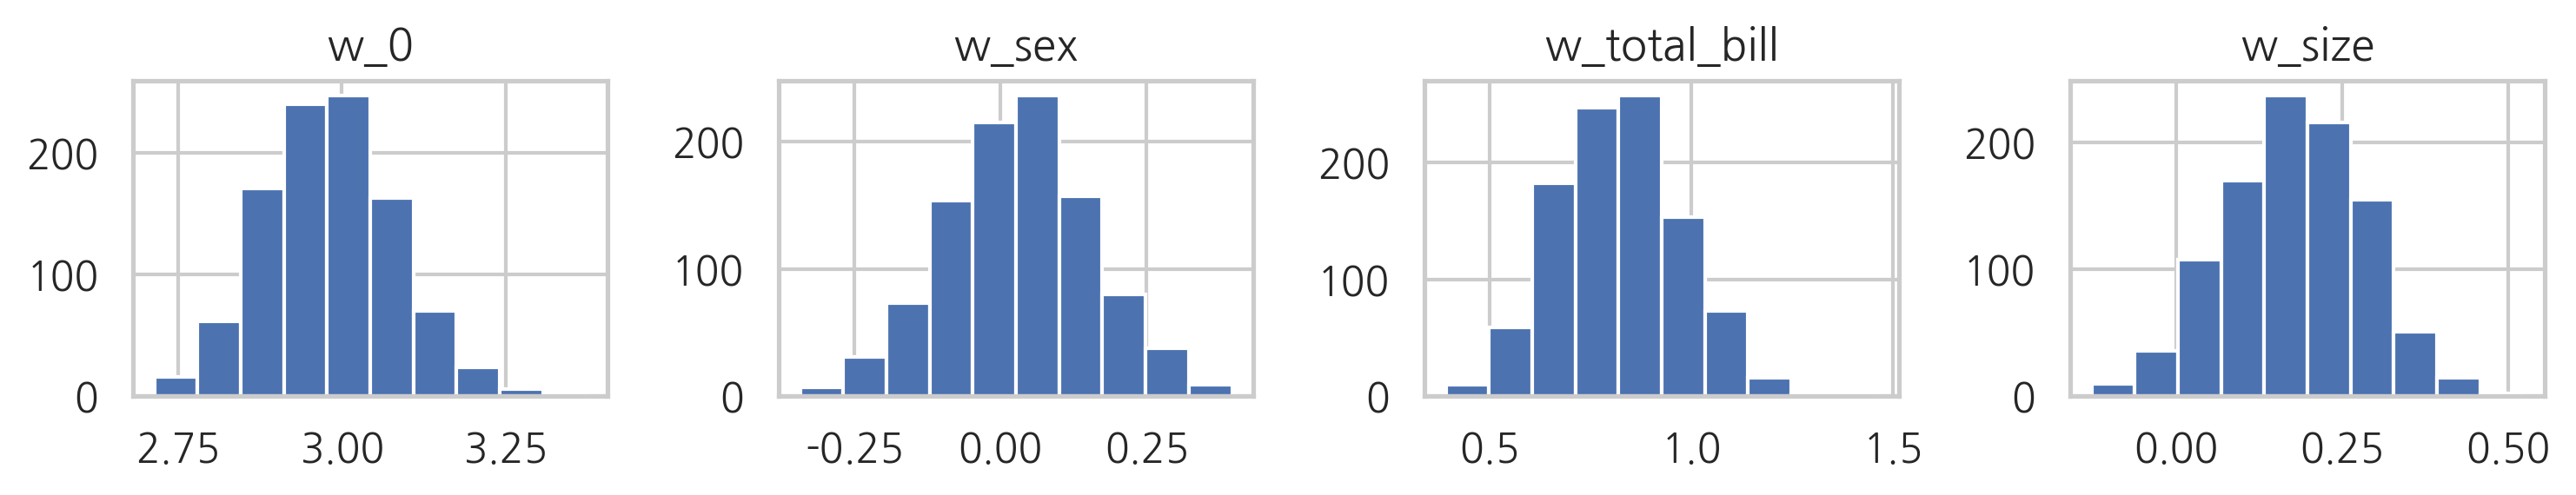

In [65]:
weights.hist(figsize=(10, 2), layout=(1, 4))
plt.tight_layout()
plt.show()

이 가중치 추정값들의 간단한 통계는 다음과 같다.

In [66]:
weights.describe()

,w_0,w_sex,w_total_bill,w_size
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.982061,0.032277,0.824139,0.178676
std,0.099503,0.124839,0.151586,0.104542
min,2.714403,-0.342809,0.391266,-0.127939
25%,2.912348,-0.052066,0.711447,0.103797
50%,2.979314,0.033755,0.821183,0.179384
75%,3.048256,0.113475,0.924565,0.252902
max,3.372273,0.395771,1.461748,0.523164


total_bill 변수의 가중치는 평균적으로 0.8정도이고 0.4~1.5 정도의 범위에 있는 것을 알 수 있다. 어떤 경우든 음수가 나오는 경우는 없다. 즉 total_bill 값이 커질수록 팁이 증가하는 결과는 변함없다. 하지만 sex 변수의 가중치는 -0.3 ~ 0.3 범위의 값이 나온다. 즉 음수인 경우도 나오고 양수인 경우도 나온다. 이는 sex 변수가 팁에 미치는 영향을 정확히 분석할 수 없다는 뜻이다.